In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import roc_curve

In [2]:
data=pd.read_csv("Fraud_Data.csv")
data['ip_address']=round(data['ip_address'])
  
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
ip_addresses=pd.read_csv('IpAddress.csv')
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
# Determin user country based on Ip address
data_country = [None] * data.shape[0]
  
for i in range(data.shape[0]):
    tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                       (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])]['country'].values
    if (len(tmp) == 1):  
        data_country[i] = tmp


In [5]:
data['country'] = data_country
data['country'] = data['country'].str.get(0)

In [6]:
data.groupby('country').size().sort_values(ascending = False)

country
United States                     58049
China                             12038
Japan                              7306
United Kingdom                     4490
Korea Republic of                  4162
                                  ...  
British Indian Ocean Territory        1
Cape Verde                            1
Guadeloupe                            1
Dominica                              1
Nauru                                 1
Length: 181, dtype: int64

# Exploratory Data Analysis

In [7]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [8]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209300e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [9]:
# certain country has highrt fraud rate
group_by_country = data.groupby(['country'])['class'].mean()
group_by_country_df = pd.DataFrame(index = group_by_country.index,columns= ['fraud_rate'] )
group_by_country_df['fraud_rate'] = group_by_country.values
group_by_country_df.sort_values(by=['fraud_rate'], ascending = False)

,fraud_rate
country,
Turkmenistan,1.000000
Namibia,0.434783
Sri Lanka,0.419355
Luxembourg,0.388889
Virgin Islands (U.S.),0.333333
...,...
Guadeloupe,0.000000
Gibraltar,0.000000
Ghana,0.000000


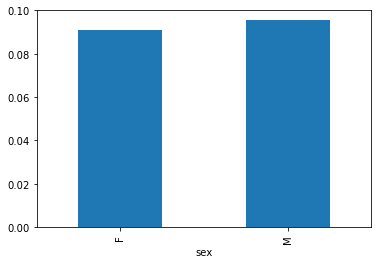

In [10]:
data.groupby(['sex'])['class'].mean().plot.bar()
plt.show()

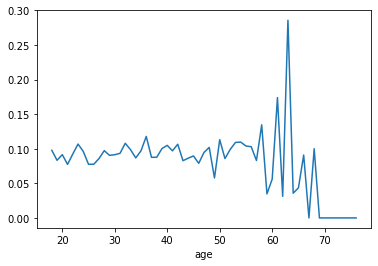

In [11]:
data.groupby(['age'])['class'].mean().plot()
plt.show()

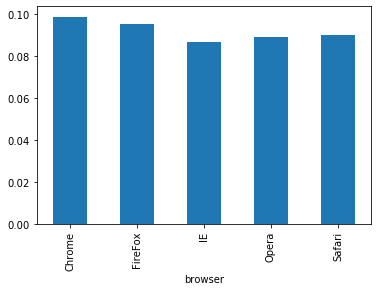

In [12]:
data.groupby(['browser'])['class'].mean().plot.bar()
plt.show()

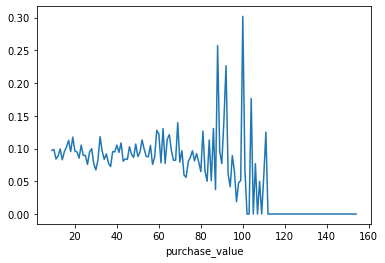

In [13]:
# purchase of more expensive items are more likely to be fraud
data.groupby(['purchase_value'])['class'].mean().plot()
plt.show()

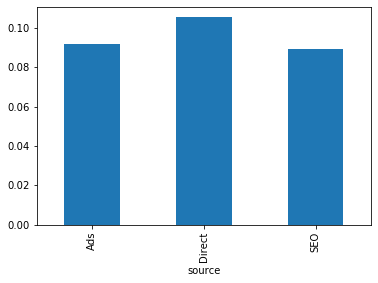

In [14]:
data.groupby(['source'])['class'].mean().plot.bar()
plt.show()

# Feature Engineering 

Possible indicators of fraudulent accounts: 

- Multiple accounts on the same device


- Multiple accounts on the same device with the same ip address
 
 
- time difference between sign-up time and purchase time


In [15]:
#convert data
data["signup_time"]   = pd.to_datetime(data["signup_time"])
data["purchase_time"] = pd.to_datetime(data["purchase_time"])
#take the difference in seconds
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()

In [16]:
data['purchase_signup_diff'].describe()

count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644525e+06
max      1.036797e+07
Name: purchase_signup_diff, dtype: float64

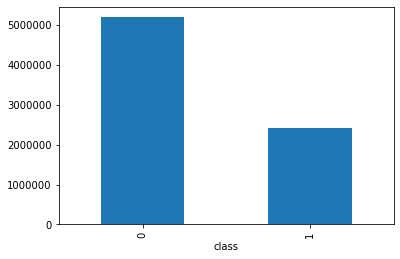

In [17]:
# fraud activities tend to have a shorter time difference 
data.groupby(['class'])['purchase_signup_diff'].mean().plot.bar()
plt.show()

In [18]:
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
  

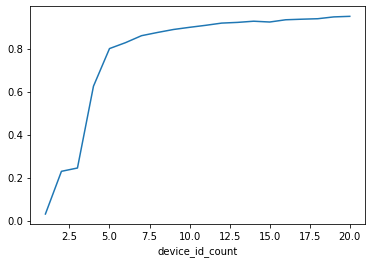

In [19]:
# users who use shared devices are more likely to perform fraud activity
data.groupby(['device_id_count'])['class'].mean().plot()
plt.show()

In [20]:
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

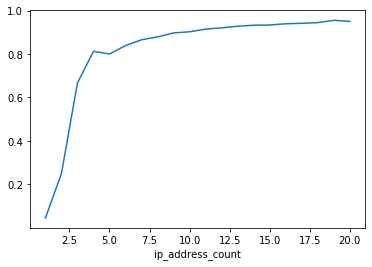

In [21]:
# users with same ip Address are more likely to commit fraud
data.groupby(['ip_address_count'])['class'].mean().plot()
plt.show()

# Random Forest 

In [22]:
np.random.seed(46)
  
# prepare data for modeling 
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)
  
#replace NaN in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)
  
#only keep the top 50 country, everything else is "other"
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)
  
#make dummy
data_rf = pd.get_dummies(data_rf, drop_first=True) 
  
#split into train and test 
train, test = train_test_split(data_rf, test_size = 0.34)
  


In [24]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9561128212326913 
 OOB Confusion Matrix 
        0     1
0  90277    80
1   4297  5079


In [25]:
# test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.956305105198622 
 Test Set Confusion Matrix 
        0     1
0  46578    26
1   2219  2556


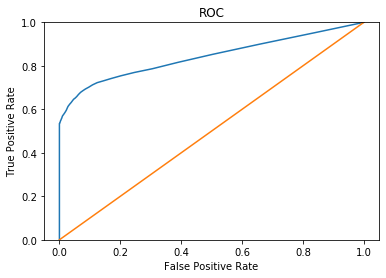

In [26]:
#cut-off optimization
#draw ROC curve
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]

pred = rf.predict(test.drop('class', axis=1))

fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)


plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

Depending on the costs of false positive vs false negatives, we can choose the optimal cutoff point to minimize the overall cost. 

If the focus is on minimizing the number of false postives, we would choose a cut-off that would give us true positive rate near 0.6 and false positive rate basically zero. If we were to capture as many positive cases as possiable, we could decrease the value of the cutoff point, so that the model will classify more events as 1. However, in this case, only events with a very low probability of being a fraud will be classfied as 0. 

Another approach is to maximize true positive rate - false positive rate. In other words, we will choose the cutoff point that maximizes (1-class1_error) - class0_error. That is, we are willing to increase class0_error by a certain number as long as class1_error goes down by a larger number.


In [28]:

error_cutoff=pd.DataFrame({'cutoff':pd.Series(thresholds),
                               'class0_error':pd.Series(fpr),
                               'class1_error': 1 - pd.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
error_cutoff.sort_values('optimal_value', ascending=False).head(1)

,cutoff,class0_error,class1_error,optimal_value
54,0.14,0.076732,0.314555,0.608713


The optimal cutoff point gives us 69% true positive rate and very low false positive rate (~7%). 

In [33]:
# predict the probabilty of a transaction being fraud in the test set
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]

In [34]:
#see how different values for cutoff point will infuence accuracy, tpr, fpr
def calculate_metric(cutoff):
    pred = np.where(pred_prob > cutoff, 1, 0)
    accuracy = np.sum(pred ==test['class'])/len(test['class'])
    tpr = np.sum((pred == test['class'] )& (pred == 1))/np.sum(test['class'] == 1)
    fpr = np.sum((pred == 1 )& (test['class']  == 0))/np.sum(test['class'] == 0)
    return accuracy, tpr, fpr

In [35]:
calculate_metric(0.14)

(0.9070242706163997, 0.6781151832460733, 0.06952192944811604)

In [36]:
calculate_metric(0.05)

(0.7556200003892641, 0.7694240837696336, 0.24579435241610162)

In [37]:
calculate_metric(0.5)

(0.956305105198622, 0.5352879581151833, 0.0005578920264354991)

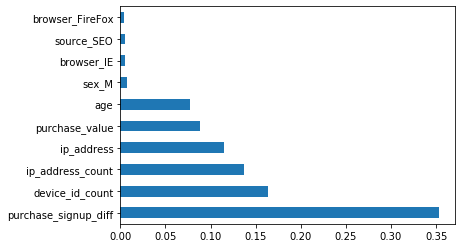

In [32]:
#look at the most important variables
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('class', axis=1).columns)
feat_importances.sort_values().nlargest(10).plot(kind='barh')
plt.show()